In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.ensemble import IsolationForest

# Connect to PostgreSQL
db_uri = {db_uri}
engine = create_engine(db_uri)

# Fetch influencer engagement data
query = """
SELECT 
    p.influencer_id,
    i.username,
    i.followers,
    SUM(pd.likes + pd.comments) / NULLIF(COUNT(pd.post_id), 0) AS engagement_rate
FROM post_details pd
JOIN posts p ON pd.post_id = p.post_id
JOIN influencers i ON p.influencer_id = i.influencer_id
WHERE i.followers IS NOT NULL
GROUP BY p.influencer_id, i.username, i.followers;
"""
df = pd.read_sql(query, engine)
engine.dispose()

# Preview data
print(df.head())


   influencer_id                 username  followers  engagement_rate
0           7901              billyilliam     128455      1550.022472
1           5915              lorianasavo      14181       475.602941
2           7831               frprlondon       8710        38.697595
3          15602          oggipaneesalame      76835       415.303030
4           2467  thechristycarlsonromano     914931     10860.152778


In [2]:
from sklearn.ensemble import IsolationForest

# Prepare data for model
X = df[["followers", "engagement_rate"]]

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df["anomaly_score"] = iso_forest.fit_predict(X)

# Label anomalies (-1 = Fake Engagement, 1 = Normal)
df["is_fake"] = df["anomaly_score"].apply(lambda x: "Fake" if x == -1 else "Legit")

# Count fake vs. real influencers
print(df["is_fake"].value_counts())

is_fake
Legit    23239
Fake      2583
Name: count, dtype: int64


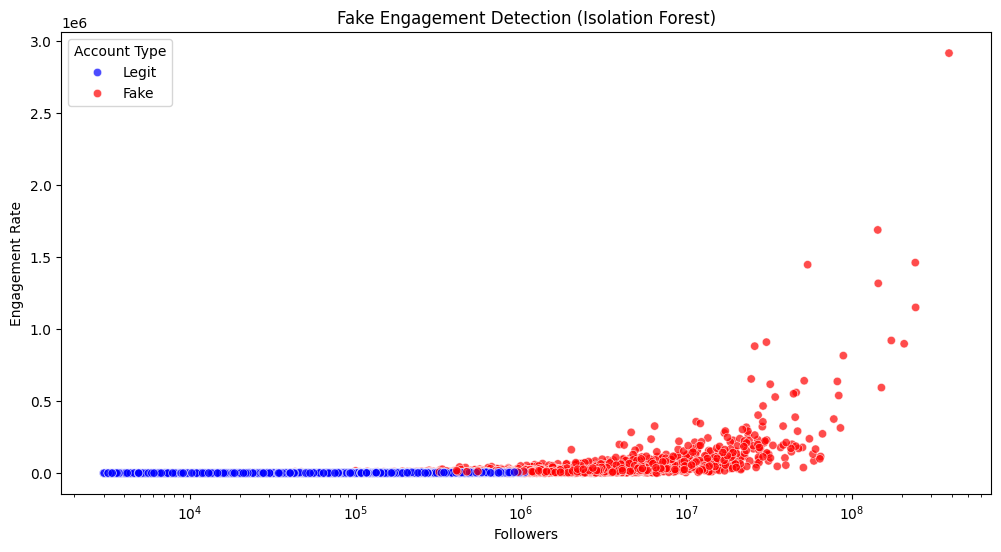

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="followers", y="engagement_rate", hue="is_fake",
                palette={"Fake": "red", "Legit": "blue"}, alpha=0.7)
plt.xlabel("Followers")
plt.ylabel("Engagement Rate")
plt.title("Fake Engagement Detection (Isolation Forest)")
plt.legend(title="Account Type")
plt.xscale("log")  # Log scale for better visualization
plt.show()

In [4]:
# Step 1: Count Fake vs. Legit Influencers
fake_count = df["is_fake"].value_counts()
fake_percentage = (fake_count["Fake"] / df.shape[0]) * 100

print(f"🔹 Total Influencers: {df.shape[0]}")
print(f"🔹 Fake Influencers: {fake_count['Fake']} ({fake_percentage:.2f}%)")
print(f"🔹 Legit Influencers: {fake_count['Legit']} ({100 - fake_percentage:.2f}%)\n")

# Step 2: Analyze Fake Accounts by Follower Range
df["Follower_Range"] = pd.cut(df["followers"], 
                              bins=[0, 10000, 50000, 100000, 500000, 1000000, np.inf], 
                              labels=["0-10k", "10k-50k", "50k-100k", "100k-500k", "500k-1M", "1M+"])

fake_by_followers = fake_by_followers = df.groupby("Follower_Range", observed=False)["is_fake"].value_counts(normalize=True).unstack() * 100

print("🔹 Fake Engagement Percentage by Follower Range:")
print(fake_by_followers, "\n")

# Step 3: Compare Engagement Rates of Fake vs. Legit Influencers
fake_vs_legit_engagement = df.groupby("is_fake")["engagement_rate"].describe()

print("🔹 Engagement Rate Comparison (Fake vs. Legit):")
print(fake_vs_legit_engagement, "\n")

🔹 Total Influencers: 25822
🔹 Fake Influencers: 2583 (10.00%)
🔹 Legit Influencers: 23239 (90.00%)

🔹 Fake Engagement Percentage by Follower Range:
is_fake              Fake       Legit
Follower_Range                       
0-10k            0.000000  100.000000
10k-50k          0.053836   99.946164
50k-100k         0.000000  100.000000
100k-500k        2.784257   97.215743
500k-1M         25.814863   74.185137
1M+             97.170732    2.829268 

🔹 Engagement Rate Comparison (Fake vs. Legit):
           count          mean            std        min          25%  \
is_fake                                                                 
Fake      2583.0  35312.346994  106951.762638  46.607843  8032.833333   
Legit    23239.0    968.772667    1257.091900   0.000000   169.000000   

                  50%           75%           max  
is_fake                                            
Fake     12795.006623  28407.573661  2.915646e+06  
Legit      475.470588   1202.015471  8.393455e+03   

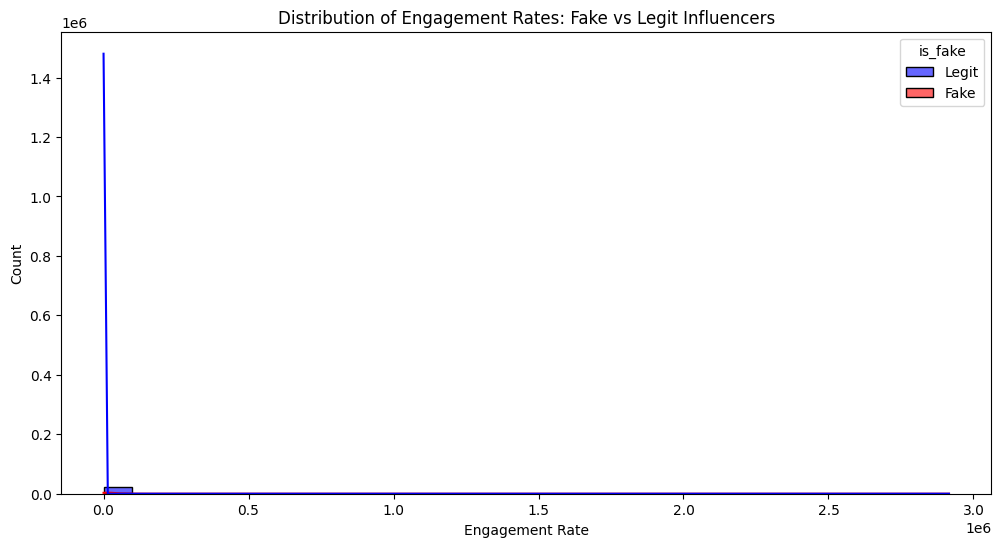

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check if we have both "Fake" and "Legit" influencers
if df["is_fake"].nunique() > 1:  # Ensure at least 2 categories exist
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x="engagement_rate", hue="is_fake", kde=True, bins=30, 
                 palette={"Fake": "red", "Legit": "blue"}, alpha=0.6)
    plt.xlabel("Engagement Rate")
    plt.ylabel("Count")
    plt.title("Distribution of Engagement Rates: Fake vs Legit Influencers")
    
    # Add legend only if both categories exist
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels) > 1:
        plt.legend(title="Account Type")
    
    plt.show()
else:
    print("⚠️ Warning: No fake influencers detected, skipping histogram.")